In [3]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [34]:
def MC_predic_time_series(data, years, iterations, name, startYear, time_type, plot=False):
    if time_type == 'bi-annual':
        data = data.groupby(np.arange(len(data))//2).mean()
    
    log_change = np.log(1+data.pct_change())
    log_change=log_change.replace([-np.inf,np.inf], np.nan).dropna()
    if plot:
        log_change.hist()
        
    u = log_change.mean() #Mean of the logarithmich chenge
    var = log_change.var() #Variance of the logarithic chenge
    drift = u - (0.5 * var) #drift / trend of the logarithmic chenge
    stdev = log_change.std() #Standard deviation of the log chenge
    t_intervals = years
    pred_change = np.exp(drift + 2*stdev * norm.ppf(np.random.rand(t_intervals, iterations)))
    
    S0=data.iloc[-1]
    pred_list = np.zeros_like(pred_change)
    pred_list[0] = S0

    for t in range(1, t_intervals):
        pred_list[t] = pred_list[t - 1] * pred_change[t]

    pred_list = pd.DataFrame(pred_list)
    pred_list['Value'] = pred_list[0]
    
    ## Attach the original data for plotting:
    if plot:
        Value = data.values
        Value = pd.DataFrame(Value)
        monte_carlo_forecast = pd.concat([Value, pred_list])
        monte_carlo = monte_carlo_forecast.iloc[:,:].values

        year_list = np.arange(startYear,startYear+len(monte_carlo))
        plt.figure(0)
        plt.figure(figsize=(17,5))

        plt.plot(year_list, monte_carlo)
        plt.title(name)
        plt.xticks(year_list[::4])
        plt.show()
    
    return pred_list


In [35]:
def MC_predic_contract_price(price_range, iterations, plot=False):
    if time_type == 'bi-annual':
        data = data.groupby(np.arange(len(data))//2).mean()
    
    log_change = np.log(1+data.pct_change())
    log_change=log_change.replace([-np.inf,np.inf], np.nan).dropna()
    if plot:
        log_change.hist()
        
    u = log_change.mean() #Mean of the logarithmich chenge
    var = log_change.var() #Variance of the logarithic chenge
    drift = u - (0.5 * var) #drift / trend of the logarithmic chenge
    stdev = log_change.std() #Standard deviation of the log chenge
    t_intervals = years
    pred_change = np.exp(drift + 2*stdev * norm.ppf(np.random.rand(t_intervals, iterations)))
    
    S0=data.iloc[-1]
    pred_list = np.zeros_like(pred_change)
    pred_list[0] = S0

    for t in range(1, t_intervals):
        pred_list[t] = pred_list[t - 1] * pred_change[t]

    pred_list = pd.DataFrame(pred_list)
    pred_list['Value'] = pred_list[0]
    
    ## Attach the original data for plotting:
    if plot:
        Value = data.values
        Value = pd.DataFrame(Value)
        monte_carlo_forecast = pd.concat([Value, pred_list])
        monte_carlo = monte_carlo_forecast.iloc[:,:].values

        year_list = np.arange(startYear,startYear+len(monte_carlo))
        plt.figure(0)
        plt.figure(figsize=(17,5))

        plt.plot(year_list, monte_carlo)
        plt.title(name)
        plt.xticks(year_list[::4])
        plt.show()
    
    return pred_list

In [36]:
def prep_energy_prices_prediction(url, name, col_name, startYear, time_type , plot=False):

    price_data = pd.read_csv(url)
    price_data=price_data.dropna().reset_index(drop=True)
    
    price_prediction = MC_predic_time_series(price_data[col_name], years = 30, iterations=10000,
                                    name = name, startYear=startYear, time_type=time_type, plot=plot)  
    return price_prediction

def get_contract_price(df,time_laps):
    return df.iloc[time_laps]

def anual_energy_calculator(radiation_path, area, yeild, PR):
    solar_df = pd.read_csv(path)
    anual_radiation = sum(solar_df['days_in_month'].multiply(solar_df['Solar_Radiation']))
    print('anual_radiation= ', anual_radiation)
    #total solar panel area  for the project:
    anual_energy = area*anual_radiation*yeild*PR
    print('Energy= ', anual_energy, ' kW/anualy')
    return anual_energy
                         

In [37]:
def loan_return_calculator(total_investment, equity_portion, interest_rate, grace_period = 12, interest_grace = 6,
                       loan_period = 20, years = 30, yearly_payments =2 ):
    periodic_loan_return = []
    periodic_interes_return = []
    loan = total_investment - total_investment*equity_portion
    remaining_loan = loan
    for i in np.arange(1, years*yearly_payments+1):
        cur_loan_return = 0
        cur_interes_return = 0 
        if i<=loan_period*yearly_payments:
            ## Calc interest returns:
            if i>interest_grace/12*yearly_payments:
                cur_interes_return= remaining_loan*interest_rate*(1/yearly_payments)
            ## Calc loan return:
            if i>grace_period/12*yearly_payments:          
                cur_loan_return = loan/((loan_period-grace_period/12)*yearly_payments)
            
        remaining_loan = remaining_loan - cur_loan_return
        periodic_loan_return.append(cur_loan_return)
        periodic_interes_return.append(cur_interes_return)

    annual_loan_return = np.array(periodic_loan_return).reshape(int(len(periodic_loan_return)/yearly_payments), yearly_payments).sum(axis=1)
    annual_interes_return = np.array(periodic_interes_return).reshape(int(len(periodic_interes_return)/2), yearly_payments).sum(axis=1)
    
    return loan, annual_loan_return, annual_interes_return
    
   

In [38]:
def annual_revenue(prices, anual_energy, degredation, yeild = 1000, years=30, contract='agreement', infaltion=0, 
                   capacity=49500):

    #calculate capacity vector and prices matrix:
    capacity_vec = np.append(capacity*yeild, np.ones(years-1))
    price_mat = np.append(prices, np.ones((len(prices),years)))
    price_mat = np.column_stack([prices.values, np.ones((len(prices),years-1))])
    
    for i in np.arange(1,years):
        capacity_vec[i] = capacity_vec[i-1]-capacity_vec[i-1]*degredation
        
        if contract=='agreement':
            price_mat[:,i] = price_mat[:,i-1]+price_mat[:,i-1]*infaltion
        elif contract == 'open_market':
            #TODO - Complete logic here
            break
                              
    annual_revenue = price_mat*capacity_vec[:, np.newaxis].T
    total_revenue = annual_revenue.sum(axis=1)
    
    plt.figure(1)
    plt.hist(total_revenue)

    return annual_revenue

In [51]:
def cash_flow_calculator(revenue, cash_flow_data , initial_investment, equity_portion, interest_rate_range):
    columns = ['Total Expenses',
               'DSRA',
               'Interest', #VAT 
               'Taxes', 
               'Delta Working Capital',
               'Upfront Fee + Substitute Tax Capex'
               ]
    costs = cash_flow_data[columns].sum(axis=1)
    loan_vec = []
    annual_loan_return_mat = []
    total__loan_return = []
    annual_interes_return_mat = []
    total__interes_return = [] 
    annual_cash_flow = []
    if len(interest_rate_range)>1:
        interest_list = np.linspace(interest_rate_range[0],interest_rate_range[1], 5)
    else:
        interest_list = interest_rate_range
    for interest_rate in interest_list:
        loan, annual_loan_return, annual_interes_return = loan_return_calculator(initial_investment,
                                                                             equity_portion, interest_rate)
        
        loan_vec.append(loan)
        annual_loan_return_mat.append(annual_loan_return)
        total__loan_return.append(sum(annual_loan_return))
        annual_interes_return_mat.append(annual_interes_return)
        total__interes_return.append(sum(annual_interes_return))
        
        #calculate cash flow
        
        costs = costs + annual_loan_return + annual_interes_return
        costs = costs.T
        annual_cash_flow.append(revenue-costs.values)

    
    df = pd.DataFrame( {'interest_list':interest_list, 
                        'total__loan_return': total__loan_return, 
                        'total__interes_return':total__interes_return,
                        'loan_val':loan_vec}, index=interest_list)
    
    axes = df[['total__loan_return', 'total__interes_return']].plot.bar(stacked=True)
    axes.legend(loc=2) 

    return annual_cash_flow
 

In [40]:

def payback_calculator(vec,initial_investment):
    cum_cashflow = np.cumsum(vec)
    
    if np.any(cum_cashflow>0):
        final_full_year = np.max(np.where(cum_cashflow<=0))
        fraction_year=0

        if final_full_year<len(cum_cashflow)-1:
            fraction_year = -cum_cashflow[final_full_year]/cum_cashflow[final_full_year+1]

        payback_period = final_full_year+fraction_year
        return payback_period
    else:
        #TODO: Decide what to do without payback
        return



In [61]:
def irr_calculator(initial_investment, cash_flow_vec, cost_of_capital):
    irr_vec = []
    npv_vec = []
    payback_vec = []
    no_payback_count = 0
    for cash_flow in cash_flow_vec:
        for year in cash_flow:
            vec = np.append(-initial_investment,year)
            irr = np.irr(vec)
            irr_vec.append(irr)
            npv_vec.append(np.npv(cost_of_capital, np.append(-initial_investment,year)))
            ##payback calculation
            payback = payback_calculator(vec,initial_investment)
            if payback:
                payback_vec.append(payback)
            else: no_payback_count = no_payback_count + 1
            
    # Plot histogram of IRR
    plt.figure(3)
    plt.hist(irr_vec, bins=100)
    plt.axvline(x=0.05, color='k')
#     plt.xlim((-1,8))
    plt.title("IRR histogram")
    print("mean IRR :", np.mean(irr_vec))
    
    #Plot histogram of NPV
    plt.figure(4)
    plt.hist(npv_vec, bins=100)
    plt.axvline(x=np.mean(npv_vec), color='g')
    print("mean npv :", np.mean(npv_vec))
#     plt.xlim((-5.65026351e+04,0.4e+10))
    plt.title("NPV histogram")
    
    # Plot histogram of Payback
    plt.figure(5)
    plt.hist(payback_vec, bins=100)
#     plt.axvline(x=0.05, color='k')
    plt.title("Payback histogram")
#     plt.xlim((0,20))
    print("mean payback :", np.mean(payback_vec))
    print('no_payback_portion: ', no_payback_count/len(irr_vec))
    
    
    return irr_vec, npv_vec, payback_vec

mean IRR : nan
mean npv : -64410093.59090786
mean payback : 15.186338641497612
no_payback_portion:  0.9
voltality:  135204746.02711925
prob_lower_then_threshold:  0.4


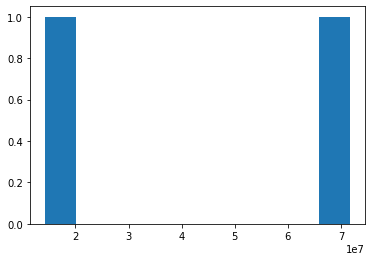

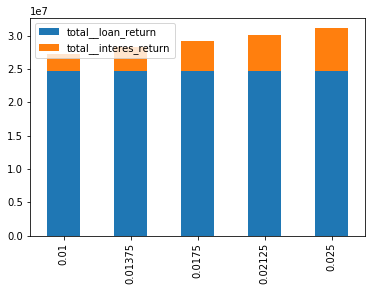

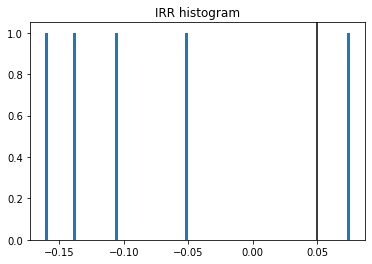

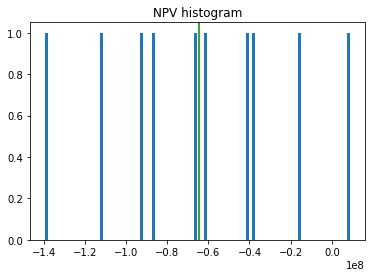

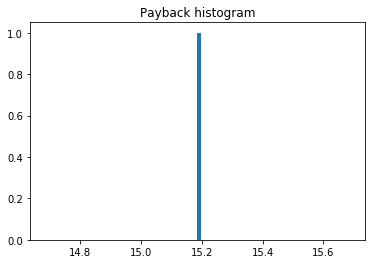

In [62]:
## main procedure

# price_prediction_household = prep_energy_prices_prediction(
#                                 r'C:\Users\Yair\Documents\Green Ensis\Data\energy_prices_italy_households.csv', 
#                                 name='Energy Prices for household Costumers', col_name='Value',startYear=2010 ,
#                                 time_type='bi-annual', plot=False)

# price_prediction_non_household = prep_energy_prices_prediction(
#                                 r'C:\Users\Yair\Documents\Green Ensis\Data\energy_prices_italy.csv', 
#                                 name='Energy Prices for non-household Costumers', col_name='Value',startYear=2010 ,
#                                 time_type='bi-annual', plot=False)

# FeedInTarif_prediction = prep_energy_prices_prediction(
#                                 r'C:\Users\Yair\Documents\Green Ensis\Data\FeedInTarrifItaly.csv', 
#                                 name='Feed-in Tariff prediction for solar PV Italy', col_name='Value', startYear=2005,
#                                 time_type='annual', plot=False)

# houshold_cotract_price_vec = get_contract_price(price_prediction_household, time_laps=4)
# non_houshold_cotract_price_vec = get_contract_price(price_prediction_non_household, time_laps=4)
# FeedInTariff_cotract_price_vec = get_contract_price(FeedInTarif_prediction, time_laps=5)

# print('FeedInTariff_cotract_price_ mean:',np.mean(FeedInTariff_cotract_price_vec) )
# print(type(FeedInTariff_cotract_price_vec))
FeedInTariff_cotract_price_vec = pd.Series([0.01,0.05])
# Area = 20000
# yeild = 18.5/100
# PR = 0.75
# path = r'C:\Users\Yair\Documents\Green Ensis\Data\solar_radiation_Italy.csv'
# anual_energy = anual_energy_calculator(path, Area, yeild, PR)
# curve_info = IV_curve_calculator()
annual_revenue_MC = annual_revenue(FeedInTariff_cotract_price_vec, anual_energy=49500, degredation=0.0025, infaltion=0)
# print(annual_revenue_MC)
cash_flow_data = pd.read_csv(r'C:\Users\Yair\Documents\Green Ensis\Data\cash_flow_data.csv')
# print(cash_flow_data['Total Expenses'])
initial_investment= 30937500
equity_portion = 0.2
interest_rate_range = [0.01,0.025] #intervals 0.001 
levered_equity_cash_flows_post_tax = cash_flow_calculator(annual_revenue_MC, cash_flow_data, 
                                                          initial_investment, equity_portion, interest_rate_range)



irr_vec, npv_vec, payback_vec = irr_calculator(initial_investment*equity_portion, levered_equity_cash_flows_post_tax,
                                               cost_of_capital = 0.015)
voltality = np.std(npv_vec)*np.sqrt(len(npv_vec))
print('voltality: ', voltality)

treshold = 0.05
prob_lower_then_threshold = sum(irr<0.05 for irr in irr_vec)/len(irr_vec)
print('prob_lower_then_threshold: ', prob_lower_then_threshold)




In [16]:
## Calculate probability under minimun rate of atractiveness
treshold = 0.05
prob_lower_then_threshold = sum(irr<0.05 for irr in irr_vec)/len(irr_vec)
print('prob_lower_then_threshold: ', prob_lower_then_threshold)

prob_lower_then_threshold:  0.20727927207279273


In [76]:
df = pd.read_csv(r'C:\Users\Yair\Documents\Green Ensis\Data\output.csv')
irr_vec = df['irr_vec']

In [1]:
from matplotlib.ticker import PercentFormatter

df = pd.read_csv(r'C:\Users\Yair\Documents\Green Ensis\Data\output.csv')
irr_vec = df['irr_vec']
# Plot histogram of IRR
plt.figure(12)
plt.hist(irr_vec*100, bins=100, weights=np.ones(len(irr_vec)) / len(irr_vec))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
# plt.axvline(x=0.05, color='k')
plt.title("IRR histogram")
plt.xlabel('IRR [%]')
plt.ylabel('% scenarios')
plt.show()

npv_vec = df['npv_vec']
#Plot histogram of NPV
plt.figure(13)
plt.hist(npv_vec/1000000, bins=100 , weights=np.ones(len(npv_vec)) / len(npv_vec))
plt.axvline(x=np.mean(npv_vec)/1000000, color='g')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('NPV [M Euro]')
plt.ylabel('% scenarios')
print("mean npv :", np.mean(npv_vec))
# plt.xlim((-5.65026351e+04,0.4e+10))
plt.title("NPV histogram")

payback_vec = df['payback_vec']
plt.figure(5)
plt.hist(payback_vec, bins=100 , weights=np.ones(len(payback_vec)) / len(payback_vec))
#     plt.axvline(x=0.05, color='k')
plt.title("Payback histogram")
plt.xlabel('payback [years]')
plt.ylabel('% scenarios')
# plt.xlim((0,100))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
print("mean payback :", np.mean(payback_vec))


NameError: name 'pd' is not defined

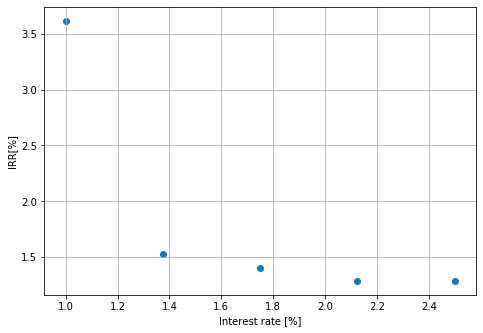

In [22]:
interest_rate_range=[0.01,0.025]
interest_list = np.linspace(interest_rate_range[0],interest_rate_range[1], 5)


fig = plt.figure(10)
ax = fig.add_axes([0,0,1,1])
ax.scatter(interest_list*100,irr_vec*100)
plt.xlabel('Interest rate [%]')
plt.ylabel('IRR[%]')
plt.grid()
plt.show()


mean npv : 268814813.1010881


Text(0.5, 1.0, 'NPV histogram')

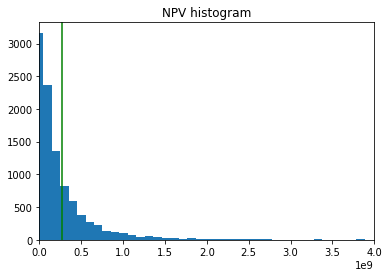

In [18]:
#Plot histogram of NPV
plt.hist(npv_vec, bins=100)
plt.axvline(x=np.mean(npv_vec), color='g')
print("mean npv :", np.mean(npv_vec))
plt.xlim((-5.65026351e+04,0.4e+10))
plt.title("NPV histogram")

In [10]:
from pvlib import pvsystem
# Example module parameters for the Canadian Solar CS5P-220M:
def IV_curve_calculator():
    parameters = {
        'Name': 'Canadian Solar CS6K- 300',
        'BIPV': 'N',
        'Date': '1/1/2020',
        'T_NOCT': 42.4,
        'A_c': 1.7,
        'N_s': 96,
        'I_sc_ref': 9.99,
        'V_oc_ref': 40.1,
        'I_mp_ref': 4.69,
        'V_mp_ref': 46.9,
        'alpha_sc': 0.05,
        'beta_oc':-0.39,
        'a_ref': 2.6373,
        'I_L_ref': 5.114,
        'I_o_ref': 8.196e-10,
        'R_s': 1.065,
        'R_sh_ref': 381.68,
        'Adjust': 8.7,
        'gamma_r': -0.29,
        'Version': 'MM106',
        'PTC': 200.1,
        'Technology': 'Mono-c-Si'
    }

    cases = [
        (1000, 55)
        ]

    conditions = pd.DataFrame(cases, columns=['Geff', 'Tcell'])

    # adjust the reference parameters according to the operating
    # conditions using the De Soto model:
    IL, I0, Rs, Rsh, nNsVth = pvsystem.calcparams_desoto(
        conditions['Geff'],
        conditions['Tcell'],
        alpha_sc=parameters['alpha_sc'],
        a_ref=parameters['a_ref'],
        I_L_ref=parameters['I_L_ref'],
        I_o_ref=parameters['I_o_ref'],
        R_sh_ref=parameters['R_sh_ref'],
        R_s=parameters['R_s'],
        EgRef=1.121,
        dEgdT=-0.0002677
    )

    # plug the parameters into the SDE and solve for IV curves:
    curve_info = pvsystem.singlediode(
        photocurrent=IL,
        saturation_current=I0,
        resistance_series=Rs,
        resistance_shunt=Rsh,
        nNsVth=nNsVth,
        ivcurve_pnts=100,
        method='lambertw'
    )
    
    # plot the calculated curves:
    plt.figure()
    for i, case in conditions.iterrows():
        label = (
            "$G_{eff}$ " + f"{case['Geff']} $W/m^2$\n"
            "$T_{cell}$ " + f"{case['Tcell']} $C$"
        )
    plt.plot(curve_info['v'][i], curve_info['i'][i], label=label)
    v_mp = curve_info['v_mp'][i]
    i_mp = curve_info['i_mp'][i]
    # mark the MPP
    plt.plot([v_mp], [i_mp], ls='', marker='o', c='k')

    plt.legend(loc=(1.0, 0))
    plt.xlabel('Module voltage [V]')
    plt.ylabel('Module current [A]')
    plt.title(parameters['Name'])
    plt.show()
    plt.gcf().set_tight_layout(True)
    
    return curve_info

In [19]:
import pandas as pd
input_df = pd.DataFrame({'annual_production_capacity': [49500] , 
                         'contract_tarrif_range': [0.045] ,  #[0.045][0.04,0.05][0.01,0.05]
                        'production_degredeation':[0.0025],
                        'project_years': [30] ,
                         'yeild':[1000],
                         'inflation':[0],
                         'initial_investment':[30937500],
                         'equity_portion':[0.2],
                         'interest_rate_range':[[0.01,0.025]], #0.013 [0.01,0.025]
                         'interest_diff': [0.001], 
                         'cost_of_capital': [0.015] #
                        })

df = input_df.to_csv(r'C:\Users\Yair\Documents\Green Ensis\Data\inputFile.csv')


In [22]:
inputFile = pd.read_csv(r'C:\Users\Yair\Documents\Green Ensis\Data\inputFile.csv')
print(eval(inputFile['contract_Tarrif_range'].values[0]))
print(inputFile['annual_production_capacity'].values[0])

[0.01, 0.05]
49500


In [8]:
a = [1,2,3]

b = [True,False,True]

a[]

TypeError: list indices must be integers or slices, not tuple